# Candidate Generation and LGBM

## 1. Setup and imports

* pip install pyarrow (for loading parquets)
* pip install lightgbm (May require installation of other packages: https://github.com/microsoft/LightGBM/tree/master/python-package)

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np

from average_precision import apk, mapk

In [2]:
# Helper functions for improving memory
# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
def hex_id_to_int(str):
    return int(str[-16:], 16)

def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

All categorical columns in transactions, customers, and articles have been converted into a numerical code within the saved parquet. All NaN values were replaced with -1. LGBM models perform best when the categorical columns are encoded as integers. 

## 2. Load data

In [29]:
transactions_train = pd.read_parquet('data/transactions_train_sample_gt15transactions.parquet')
customers = pd.read_parquet('data/customers.parquet')
articles = pd.read_parquet('data/articles.parquet')
transactions_val = pd.read_parquet('data/transactions_val.parquet')

In [7]:
transactions_train.shape[0] + transactions_val.shape[0]

1036592

In [4]:
transactions = pd.concat([transactions_train, transactions_val])

In [6]:
transactions.shape

(1036592, 6)

### Transactions data

In [8]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
0,2018-09-20,49501769952275870,615508002,0.016932,1,0
1,2018-09-20,50555163119119323,496111007,0.033881,2,0
2,2018-09-20,50555163119119323,651273001,0.022017,2,0
3,2018-09-20,50555163119119323,613826004,0.042356,2,0
4,2018-09-20,120750557174833794,662888004,0.033881,1,0


In [10]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036592 entries, 0 to 240310
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1036592 non-null  datetime64[ns]
 1   customer_id       1036592 non-null  uint64        
 2   article_id        1036592 non-null  int32         
 3   price             1036592 non-null  float32       
 4   sales_channel_id  1036592 non-null  int8          
 5   week              1036592 non-null  int8          
dtypes: datetime64[ns](1), float32(1), int32(1), int8(2), uint64(1)
memory usage: 33.6 MB


Number of transactions made per week

<AxesSubplot:title={'center':'Number of Transactions per Week'}>

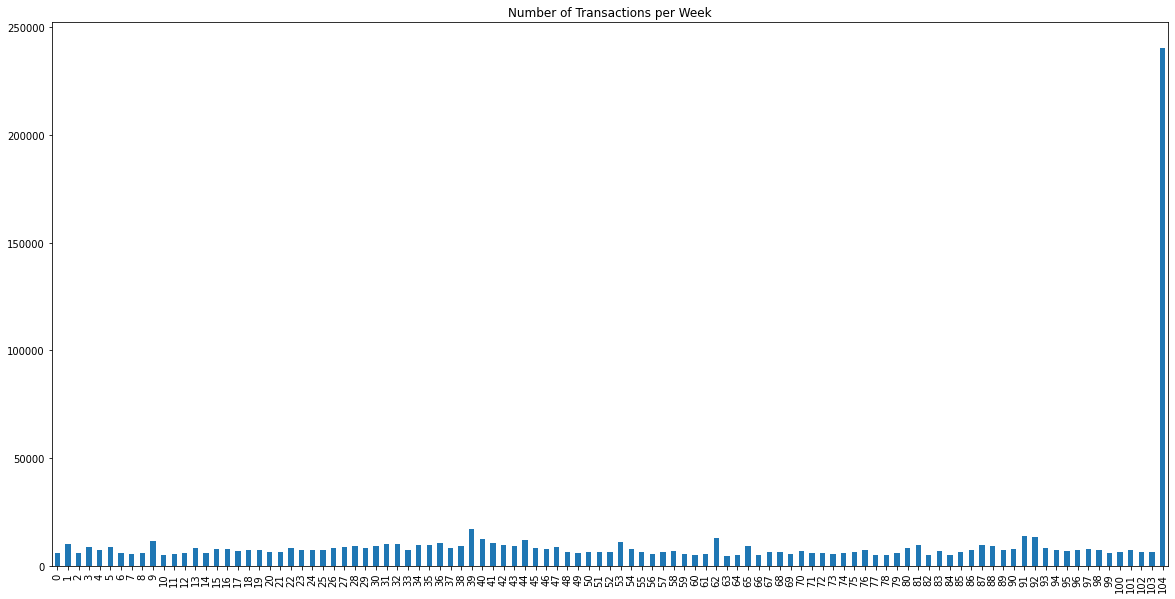

In [11]:
transactions['week']\
    .value_counts()\
    .sort_index()\
    .plot(figsize = (20, 10), kind='bar', title = 'Number of Transactions per Week')

## 5. Train, validation, test split

"Leave One Last Item" train, validation, test split from https://arxiv.org/pdf/2007.13237.pdf

TODO - Make sure Marina's collaborative filtering only uses the data from the train transactions

In [13]:
val_week = transactions["week"].max() # Last week in the training set

# train/ val transactions sets
train_transactions = transactions[transactions["week"] != val_week] 
val_transactions = transactions[transactions["week"] == val_week].reset_index(drop = True)

In [14]:
train_transactions.shape

(796281, 6)

In [15]:
val_transactions.shape

(240311, 6)

## 6. Candidate Generation

df with each customers last transaction. This will be the base df that we will merge all generated candidates into

In [16]:
# The transaction of each customers last transaction
unique_customers = transactions \
    .groupby(['customer_id']) \
    .tail(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()
unique_customers['week'].value_counts()[104]

68984

### 6.1 Collaborative Filtering Results

Read collaborative filtering csv results

In [17]:
customers_rec_articles = pd.read_csv("customers_recommended_articles.csv")
customers_rec_articles.head()

,customer_id,recom_articles
0,345001598676045,"[827968001, 708352002, 557248002, 626816004, 8..."
1,1134266496627188,"[804992001, 821152002, 536139011, 906880003, 3..."
2,1845857727772358,"[593557001, 763712010, 821397008, 719530003, 6..."
3,7252995555838753,"[739819009, 716672001, 757995009, 786304003, 8..."
4,8421185370332018,"[490176001, 716224001, 819520003, 793856003, 7..."


In [18]:
customers_rec_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15333 entries, 0 to 15332
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     15333 non-null  uint64
 1   recom_articles  15333 non-null  object
dtypes: object(1), uint64(1)
memory usage: 239.7+ KB


Merge the recommended articles with the transaction data to generate negative samples

In [19]:
collab_candidates = pd.merge(
    unique_customers, # base df to merge all results into
    customers_rec_articles, # collaborative filtering results
    on='customer_id'
)

collab_candidates.head()

,t_dat,customer_id,sales_channel_id,week,recom_articles
0,2018-09-20,7748846168934899318,1,0,"[603584001, 612800008, 796053001, 591701002, 7..."
1,2018-09-23,3046283554586632105,2,0,"[508544001, 671232002, 752000003, 742912002, 8..."
2,2018-09-26,4361157173718303054,1,1,"[705557001, 532138001, 610776082, 876351002, 5..."
3,2018-09-29,3704873858974099101,1,1,"[676352001, 701952003, 639573001, 775210001, 7..."
4,2018-09-29,9321548578656156180,1,1,"[520427009, 694848005, 752512007, 705557001, 7..."


recom_articles column is a list as a *string* type. Use json (as shown below) to convert the data into a list (of list type) as desired

In [20]:
import json
collab_candidates['recom_articles'] = collab_candidates['recom_articles'].apply(lambda x: json.loads(x))

Create one row per customer_id, article_id combination

In [21]:
collab_candidates = collab_candidates.explode('recom_articles').reset_index(drop=True)

# rename recom_articles to article_id to match other schema
collab_candidates['article_id'] = collab_candidates['recom_articles'] 
collab_candidates = collab_candidates.drop('recom_articles', axis = 1)

collab_candidates.head()

,t_dat,customer_id,sales_channel_id,week,article_id
0,2018-09-20,7748846168934899318,1,0,603584001
1,2018-09-20,7748846168934899318,1,0,612800008
2,2018-09-20,7748846168934899318,1,0,796053001
3,2018-09-20,7748846168934899318,1,0,591701002
4,2018-09-20,7748846168934899318,1,0,727808010


In [22]:
collab_candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2948506 entries, 0 to 2948505
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       uint64        
 2   sales_channel_id  int8          
 3   week              int8          
 4   article_id        object        
dtypes: datetime64[ns](1), int8(2), object(1), uint64(1)
memory usage: 73.1+ MB


Address format of article_id. Drop null rows and convert strings to the correct article_id format

In [23]:
def article_id_str_to_int(series):
    return series.astype('int32')

collab_candidates = collab_candidates.dropna()

collab_candidates['article_id'] = article_id_str_to_int(collab_candidates['article_id'])
collab_candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2948506 entries, 0 to 2948505
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       uint64        
 2   sales_channel_id  int8          
 3   week              int8          
 4   article_id        int32         
dtypes: datetime64[ns](1), int32(1), int8(2), uint64(1)
memory usage: 61.9 MB


TODO? Approach 1: Identify items that customers last purchased

TODO - Approach 2: Bestsellers/ Popular candidates - identify the top 12 bestselling articles per week

## 3. Combining transactions and candidates / negative examples

Label all transactions that actually occurred as 1 (positive samples)

Comment from Pawel in Kaggle discussion here: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/307288
In my setting I propose to convert the problem to a table where you have a list of item candidates and you mark the sales as either 0 or 1 depending whether the item was sold in the <b>next</b> week. 

Imagine you want to create negative samples as a list of 1000 most popular items in the last week. Some of those items will be bought by the customers. So the table you need to create is:
customer_id
label = whether it was bought or not
article_id from the list of 1000 most popular items
I'm not saying this is the best approach here but it is more or less what I'm doing. This is a technique where you create a set of explicit negative items. There are also techniques for implicit recommendations but all of them assume some sort of a strategy to generate negative samples.

Positive samples, all previously purchased transactions

In [24]:
transactions["purchased"] = 1 
transactions.shape

(1036592, 7)

Combine positive and negative samples

In [25]:
data = pd.concat([transactions, collab_candidates])
data.purchased.fillna(0, inplace=True) # Label all candidate generated transactions as 0

In [26]:
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
0,2018-09-20,49501769952275870,615508002,0.016932,1,0,1.0
1,2018-09-20,50555163119119323,496111007,0.033881,2,0,1.0
2,2018-09-20,50555163119119323,651273001,0.022017,2,0,1.0
3,2018-09-20,50555163119119323,613826004,0.042356,2,0,1.0
4,2018-09-20,120750557174833794,662888004,0.033881,1,0,1.0


TODO - logic here with how lgbm works. It drops duplicates. Retains the transactions (positive labels). If duplicated, will drop the duplicates in the negative samples


In [27]:
# Drops duplicates. Retains the transactions (positive labels). If duplicated, will drop the duplicates in the negative samples
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True) 
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
0,2018-09-20,49501769952275870,615508002,0.016932,1,0,1.0
1,2018-09-20,50555163119119323,496111007,0.033881,2,0,1.0
2,2018-09-20,50555163119119323,651273001,0.022017,2,0,1.0
3,2018-09-20,50555163119119323,613826004,0.042356,2,0,1.0
4,2018-09-20,120750557174833794,662888004,0.033881,1,0,1.0


TODO - add bestseller information see ranking_example.ipynb

Create a joined dataset with transaction, article, and customer information + target values (0/ 1)

In [30]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

In [31]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [32]:
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,product_code,prod_name,product_type_no,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,club_member_status,fashion_news_frequency,age,postal_code
0,2018-09-25,32004869510053717,666268001,0.033881,2,0,1.0,666268,8579,253,...,0,15,0,1010,6,36471,0,1,29.0,93042
1,2018-09-25,32004869510053717,558428001,0.035576,2,0,1.0,558428,38328,273,...,2,53,1,1009,5,30070,0,1,29.0,93042
2,2018-09-25,32004869510053717,632143001,0.033881,2,0,1.0,632143,21570,275,...,2,53,1,1012,18,20636,0,1,29.0,93042
3,2018-09-25,32004869510053717,684947002,0.028797,2,0,1.0,684947,12640,253,...,0,18,12,1003,3,20988,0,1,29.0,93042
4,2018-09-25,32004869510053717,690478001,0.033881,2,0,1.0,690478,45040,264,...,0,15,0,1023,19,35534,0,1,29.0,93042


## 4. Train/ Test data

Train data is currently all transactions from weeks 0-103. The target labels are also obtained from transactions from weeks 0-103 (confirm this is correct or whether we should be predicting the next week, ie wk104)

In [33]:
test_week = val_week

In [34]:
test_week

104

In [35]:
train = data[data.week != test_week]
train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,product_code,prod_name,product_type_no,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,club_member_status,fashion_news_frequency,age,postal_code
0,2018-09-25,32004869510053717,666268001,0.033881,2,0,1.0,666268,8579,253,...,0,15,0,1010,6,36471,0,1,29.0,93042
1,2018-09-25,32004869510053717,558428001,0.035576,2,0,1.0,558428,38328,273,...,2,53,1,1009,5,30070,0,1,29.0,93042
2,2018-09-25,32004869510053717,632143001,0.033881,2,0,1.0,632143,21570,275,...,2,53,1,1012,18,20636,0,1,29.0,93042
3,2018-09-25,32004869510053717,684947002,0.028797,2,0,1.0,684947,12640,253,...,0,18,12,1003,3,20988,0,1,29.0,93042
4,2018-09-25,32004869510053717,690478001,0.033881,2,0,1.0,690478,45040,264,...,0,15,0,1023,19,35534,0,1,29.0,93042


In [36]:
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,product_code,prod_name,product_type_no,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,club_member_status,fashion_news_frequency,age,postal_code
3347750,2020-09-22,1402273113592184,885951001,0.030492,2,104,1.0,885951,5202,306,...,0,61,5,1017,4,5645,0,0,20.0,206442
3347751,2020-09-22,1402273113592184,611415001,0.016932,2,104,1.0,611415,158,286,...,0,61,5,1017,4,28,0,0,20.0,206442
3347752,2020-09-19,1827730561464445,918603001,0.047932,1,104,1.0,918603,26329,252,...,0,15,0,1003,3,28672,0,0,30.0,305856
3347753,2020-09-19,1827730561464445,921380001,0.063898,1,104,1.0,921380,25098,264,...,0,15,0,1008,20,28745,0,0,30.0,305856
3347754,2020-09-22,1951136007097426,778745010,0.033881,1,104,1.0,778745,520,297,...,0,62,31,1017,4,1215,0,0,28.0,150297


Only use a subset of columns specified here as input into the LGBM model

In [37]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code'] #, 'bestseller_rank']

### Model input

In [38]:
train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [39]:
train_X.head()

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,club_member_status,fashion_news_frequency,age,postal_code
0,666268001,253,1010016,9,4,5,1522,0,1,15,1010,0,1,29.0,93042
1,558428001,273,1010016,9,4,5,1747,1,2,53,1009,0,1,29.0,93042
2,632143001,275,1010016,9,4,5,1444,1,2,53,1012,0,1,29.0,93042
3,684947002,253,1010016,11,1,9,1648,0,1,18,1003,0,1,29.0,93042
4,690478001,264,1010017,9,4,5,3090,0,1,15,1023,0,1,29.0,93042


In [40]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3347750 entries, 0 to 3347749
Data columns (total 15 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   article_id                  int32  
 1   product_type_no             int32  
 2   graphical_appearance_no     int32  
 3   colour_group_code           int32  
 4   perceived_colour_value_id   int32  
 5   perceived_colour_master_id  int32  
 6   department_no               int32  
 7   index_code                  int8   
 8   index_group_no              int32  
 9   section_no                  int32  
 10  garment_group_no            int32  
 11  club_member_status          int8   
 12  fashion_news_frequency      int8   
 13  age                         float64
 14  postal_code                 int32  
dtypes: float64(1), int32(11), int8(3)
memory usage: 201.1 MB


## 5. Model training

In [46]:
from lightgbm.sklearn import LGBMRanker

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [ ]:
# not sure what group = train_baskets is for
ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

In [ ]:
# Obtain feature importances
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

## 6. Calculate predictions

In [ ]:
# Predict on test_X
# Add the predictions to the test data (with customer and article id)
test['preds'] = ranker.predict(test_X)
test.head()

In [ ]:
# Obtain the products for each customer, based on highest predictions.
c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

# c_id2predicted_article_ids[28847241659200] # predicted articles for person 28847241659200

TODO

In [ ]:
# # last weeks best sellers will be used in case fewer than 12 recommendations for a customer are made
# bestsellers_last_week = \
#     bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

## 7. Evaluate results

Mileva has to continue from here. Still figuring out how this code is working.

In [ ]:
val_week_purchases_by_cust = pd.read_pickle('data/val_week_purchases_by_cust.pkl')

In [ ]:
apks = []

# If the ranking algorithm proposes fewer than 12 items. Pad with the top best sellers from the previous week
for c_id, gt in val_week_purchases_by_cust.items():
    pred = c_id2predicted_article_ids.get(c_id, [])
    # pred = pred + bestsellers_last_week
    apks.append(apk(gt, pred[:12], 12))

np.mean(apks)

## 8. Create submission

In [ ]:
sub = pd.read_csv('data/sample_submission.csv')

In [ ]:
%%time
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    # pred = pred + bestsellers_last_week
    preds.append(pred[:12])

In [ ]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [ ]:
# sub_name = 'basic_model_submission'
# sub.to_csv(f'data/subs/{sub_name}.csv.gz', index=False)

In [ ]:
# !kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f 'data/subs/{sub_name}.csv.gz' -m {sub_name}